# **Entrainement - Modèle DenseNet121**

## *Connexion Google Drive*

In [ ]:
# Connexion au google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## *Installation des packages*

In [ ]:
pip install sklearn

In [ ]:
pip install tensorflow

     |████████████████████████████████| 462 kB 7.8 MB/s 


In [ ]:
pip install split-folders

In [ ]:
pip install pandas

In [ ]:
pip install matplotlib

In [ ]:
pip install keras

In [ ]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 133 kB 5.6 MB/s 


In [ ]:
pip install scikitlearn

ERROR: Could not find a version that satisfies the requirement scikitlearn (from versions: none)
ERROR: No matching distribution found for scikitlearn


## **Importation des librairies**

In [ ]:
# Import Libraries
import numpy as np 
import pandas as pd 
import time
import itertools

# Import sklearn librairie
from sklearn.metrics import accuracy_score

# Téléchargement de fichiers à partir de Collab
from google.colab import files

# file system libraries
import os
import os.path
from   os import path
import shutil

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# splits train folders into train/validation with stratification
import splitfolders  

# Images, Plotting
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# tensorflow - CNNs
import tensorflow as tf
import keras_tuner as kt
import keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121,InceptionV3, Xception, ResNet101
from keras_tuner.tuners import Hyperband

## **Définition des chemins et création de nouveaux dossiers pour classement**

In [ ]:
# Constants
FOLDERS     = ['train','val','test']
DIR_INPUT   = '/content/drive/MyDrive/Pathologia/Alzheimer/Alzheimer_s Dataset'
DIR_WORK    = './'
DIR_MODELS  = os.path.join('/content/drive/MyDrive/Pathologia/Modèles/','models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['Sain','Malade','Suspicion']


# Set seeds for reproducibility 
SEED        = 1985
tf.random.set_seed(SEED)
np.random.seed(SEED)

## **Determination du nombre d'images pour chaque classes (affichage du nombre d'images dans chaque classes)**


In [ ]:
def images_by_class(path,folders):
    """
    Loop through the path/folders count the number and proportions of each class
    """
    
    # accumulators
    sain,suspicion,malade =0,0,0
    
    # print header
    msg = '{:8} {:8} {:11} {:9} {:9} {:13} {:11}'.format('folder','sain','suspicion','malade',
                                                        'sain %','suspicion %','malade %')
    print(msg)  
    print("-"*len(msg))
    
    for folder in FOLDERS:
        for dirname,_, filenames in os.walk(os.path.join(path,folder)):
            for file in filenames:
                if "Sain" in dirname:
                    sain+=1
                if "Suspicion" in dirname:
                    suspicion+=1
                if 'Malade' in dirname:
                    malade+=1
                    
        # calculate total and percentages            
        total = sain+suspicion+malade
        if total >0:
            s  = round((sain/total)*100,1)
            su = round((suspicion/total)*100,1)
            m =round((malade/total)*100,1)
        else:
            s,su,m = 0,0,0
        
        print("{:6} {:8} {:11} {:9} {:8} {:13} {:11}".format(folder,sain,suspicion,malade,s,su,m))
        sain,suspicion,malade =0,0,0

# Images by class in the input directory
images_by_class(DIR_INPUT,FOLDERS)

folder   sain     suspicion   malade    sain %    suspicion %   malade %   
---------------------------------------------------------------------------
train      2560        1792       769     50.0          35.0        15.0
val           0           0         0        0             0           0
test        640         448       191     50.0          35.0        14.9


In [ ]:
# create a new directory if it doesn't exist
def create_dir(dir_path,folder,verbose=True):
    """
    Create the dir_path/folder if it doesn't already exist
    """
    msg = ""
    folder_path = os.path.join(dir_path,folder)
    
    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)
        
    return folder_path

# create model directory
create_dir(DIR_WORK,'models',True)

./models created


'./models'

## **Création d'un nouveau dossier 'Validation' (division du train en train et validation)**

In [ ]:
def resample_train_val_images(input_dir,working_dir,seed=SEED,split = (0.80,0.20)):
    """
    Resample the train images into train/val by the ratios given in split
    """
    # get paths
    dir_test   = os.path.join(input_dir,'test')
    dir_train  = os.path.join(input_dir,'train')
    

    # remove existing files/folders
    for folder in FOLDERS:
        if path.exists(os.path.join(working_dir,folder)):
            shutil.rmtree(os.path.join(working_dir,folder))

            
    # copy the test directory to working
    shutil.copytree(dir_test, os.path.join(working_dir,'test'))
        

    # resample
    splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split) 
        
    # print image summary by folder
    print("\n Images By Class After Resampling")
    print("-"*67)
    images_by_class(working_dir,FOLDERS)
    
    
resample_train_val_images(DIR_INPUT,DIR_WORK)

Copying files: 5121 files [01:13, 70.06 files/s] 


 Images By Class After Resampling
-------------------------------------------------------------------
folder   sain     suspicion   malade    sain %    suspicion %   malade %   
---------------------------------------------------------------------------
train      2048        1433       615     50.0          35.0        15.0
val         512         359       154     50.0          35.0        15.0
test        640         448       191     50.0          35.0        14.9


##  **Redimensionnement des images et  convertion en RGB**

In [ ]:
IMG_SIZE = [176,208]
BATCH_SIZE = 32

# Scale Images
train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)


# Image Generators
# train images: 4098
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          # convert to rgb
    seed        = SEED 
)

# validation images: 1023
val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    seed        = SEED
)

# test images:1279
test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         # convert to rgb
    seed        = SEED,
    shuffle     = False
)

# Training and Validation Steps
steps_per_epoch  = train_gen.n // train_gen.batch_size
print("steps per epoch:{}".format(steps_per_epoch))

Found 4096 images belonging to 3 classes.
Found 1025 images belonging to 3 classes.
Found 1279 images belonging to 3 classes.
steps per epoch:128


## **Visualisation des images avec les labels**

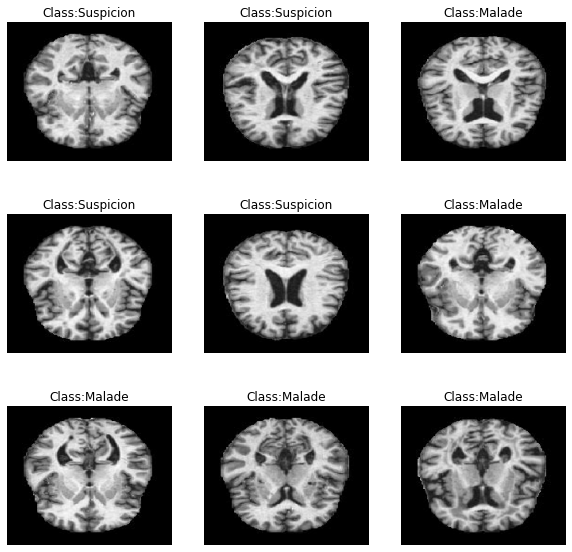

In [ ]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2], CLASS_LIST))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[i])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_gen)

## **Calcul et affichage des metriques dans des tableaux ou graphiques**

In [ ]:
from IPython.core.pylabtools import figsize
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results:
    test_loss, test_metric, test_precision, test_accuracy, test_recall, test_f1_score  = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100 
    results_title ="\n Model AUC on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    precision_values      = history_dict['precision']
    val_precision_values  = history_dict['val_precision']
    accuracy_values      = history_dict['accuracy']
    val_accuracy_values  = history_dict['val_accuracy']
    recall_values      = history_dict['recall']
    val_recall_values  = history_dict['val_recall']
    f1_score_values      = history_dict['f1_score']
    val_f1_score_values  = history_dict['val_f1_score']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    max_precision = np.max(val_precision_values)
    max_accuracy = np.max(val_accuracy_values)
    max_recall = np.max(val_recall_values)
    max_f1_score = np.max(val_f1_score_values)

    # create plots
    
    fig, axs = plt.subplots(2,3,figsize=(12,8))


 # plot loss by epochs
    axs.flat[0].plot(epochs, loss_values, 'bo', label = 'Training loss')
    axs.flat[0].plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    axs.flat[0].set_title('Validation Loss by Epochs')
    axs.flat[0].set_xlabel('Epochs')
    axs.flat[0].set_ylabel('Loss')
    axs.flat[0].axhline(y=min_loss,color='darkslategray', linestyle='--')
    axs.flat[0].legend()

    # plot AUC by epochs
    axs.flat[1].plot(epochs, auc_values, 'bo',label = 'Training AUC')
    axs.flat[1].plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    axs.flat[1].plot(epochs,[results/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    axs.flat[1].set_title('Validation AUC by Epochs')
    axs.flat[1].set_xlabel('Epochs')
    axs.flat[1].set_ylabel('AUC')
    axs.flat[1].axhline(y=max_auc,color='darkslategray', linestyle='--')
    axs.flat[1].legend()

    # plot precision by epochs
    axs.flat[2].plot(epochs, precision_values, 'bo', label = 'Training precision')
    axs.flat[2].plot(epochs, val_precision_values, 'cornflowerblue', label = 'Validation precision')
    axs.flat[2].set_title('Validation Precision by Epochs')
    axs.flat[2].set_xlabel('Epochs')
    axs.flat[2].set_ylabel('Precision')
    axs.flat[2].axhline(y=max_precision,color='darkslategray', linestyle='--')
    axs.flat[2].legend()

    # plot accuracy by epochs
    axs.flat[3].plot(epochs, accuracy_values, 'bo', label = 'Training accuracy')
    axs.flat[3].plot(epochs, val_accuracy_values, 'cornflowerblue', label = 'Validation accuracy')
    axs.flat[3].set_title('Validation Accuracy by Epochs')
    axs.flat[3].set_xlabel('Epochs')
    axs.flat[3].set_ylabel('Accuracy')
    axs.flat[3].axhline(y=max_accuracy,color='darkslategray', linestyle='--')
    axs.flat[3].legend()

    # plot recall by epochs
    axs.flat[4].plot(epochs, recall_values, 'bo', label = 'Training recall')
    axs.flat[4].plot(epochs, val_recall_values, 'cornflowerblue', label = 'Validation recall')
    axs.flat[4].set_title('Validation Recall by Epochs')
    axs.flat[4].set_xlabel('Epochs')
    axs.flat[4].set_ylabel('Recall')
    axs.flat[4].axhline(y=max_recall,color='darkslategray', linestyle='--')
    axs.flat[4].legend()

    # plot f1-score by epochs
    axs.flat[5].plot(epochs, f1_score_values, 'bo', label = 'Training F1-score')
    axs.flat[5].plot(epochs, val_f1_score_values, 'cornflowerblue', label = 'Validation F1-score')
    axs.flat[5].set_title('Validation F1-score by Epochs')
    axs.flat[5].set_xlabel('Epochs')
    axs.flat[5].set_ylabel('F1-score')
    axs.flat[5].axhline(y=max_f1_score,color='darkslategray', linestyle='--')
    axs.flat[5].legend()

    fig.tight_layout()

    # calculate Confusion Matrix
    cm = confusion_matrix(y_actual, y_pred)

    # create confusion matrix plot
    plt.figure(figsize(6,6))
    plt.plot()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Affichage de la valeur des métriques du modèle
    print(" ")
    print("------ Valeurs des métriques du modèle ------")
    print("Loss = ", test_loss)
    print("AUC = ", test_metric)
    print("Precision = ", test_precision)
    print("Accuracy = ", test_accuracy)
    print("Recall = ", test_recall)
    print("F1-score = ", test_f1_score)

## **Geler certaines couches du modèle pour réutiliser les poids du modèle pré-formé**

In [ ]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):
    """
    Input: A base transferable model,the layer name, the block number, the max number of blocks
           The layer name, block number and max of blocks only works with DenseNet121
    Output:Sets all layers to trainable from conv#_block_num to conv#_max_block_num
    
    """
    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model will be Trainable:")
        print("---------------------------------------------")
        
        # set all layers to not trainable
        base.trainable = False

        # loop through all layers from conv#_block# and set to true
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)
                    
                    

## **Lance le modèle avec les paramètres définis**

In [ ]:
# function to build the model
def build_transfer_model(conv_base,dropout,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    Input: a base model, dropout rate, the number of filters in the dense node, 
           the learning rate and performance metrics
    Output: A compiled CNN model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(3,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

## **Création d'une fonction pour la métrique "F1-score"**

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon()) #Faux positif = predicted_postives
    recall = true_positives / (possible_positives + K.epsilon()) # Faux negatifs = possible_positives
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## **Création d'une fonction pour la métrique "Accuracy"**

In [ ]:
def accuracy (y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip((1 - y_true)*(1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true)*(y_pred), 0, 1)))
    false_negatives = K.sum(K.round(K.clip((y_true)*(1 - y_pred), 0, 1)))
    acc_val = ((true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives))
    return acc_val

## **Paramètres du modèle pour l'apprentissage**

In [ ]:
# training parameters
EPOCHS        = 15
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 5,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 accuracy,
                 tf.keras.metrics.Recall(name='recall'),
                 f1_score
                 ]
                

# **Modèle de base de l'apprentissage (=Entrainement)**

## **Modèle DenseNet121**

29097984/29084464 [==============================] - 0s 0us/step
No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 6, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 5, 6, 1024)        0         
                                                                 
 batch_normalization (BatchN  (None, 5, 6, 1024)       4096      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 512)               15729152  
                                                                 
 dense_1 (D

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
128/128 - 54s - loss: 2.1069 - auc: 0.7157 - precision: 0.5844 - accuracy: 0.7097 - recall: 0.4473 - f1_score: 0.5084 - val_loss: 0.7756 - val_auc: 0.8315 - val_precision: 0.7477 - val_accuracy: 0.7598 - val_recall: 0.4800 - val_f1_score: 0.5656 - 54s/epoch - 422ms/step
Epoch 2/15
128/128 - 30s - loss: 0.7055 - auc: 0.8609 - precision: 0.7526 - accuracy: 0.7983 - recall: 0.5881 - f1_score: 0.6589 - val_loss: 0.6906 - val_auc: 0.8673 - val_precision: 0.7773 - val_accuracy: 0.7819 - val_recall: 0.5415 - val_f1_score: 0.6179 - 30s/epoch - 238ms/step
Epoch 3/15
128/128 - 31s - loss: 0.6012 - auc: 0.9001 - precision: 0.7806 - accuracy: 0.8236 - recall: 0.6550 - f1_score: 0.7112 - val_loss: 0.5794 - val_auc: 0.9125 - val_precision: 0.8355 - val_accuracy: 0.8327 - val_recall: 0.6390 - val_f1_score: 0.7009 - 31s/epoch - 239ms/step
Epoch 4/15
128/128 - 31s - loss: 0.5082 - auc: 0.9288 - precision: 0.8171 - accuracy: 0.8475 - recall: 0.6990 - f1_score: 0.7527 - val_loss: 0.5422 - val_

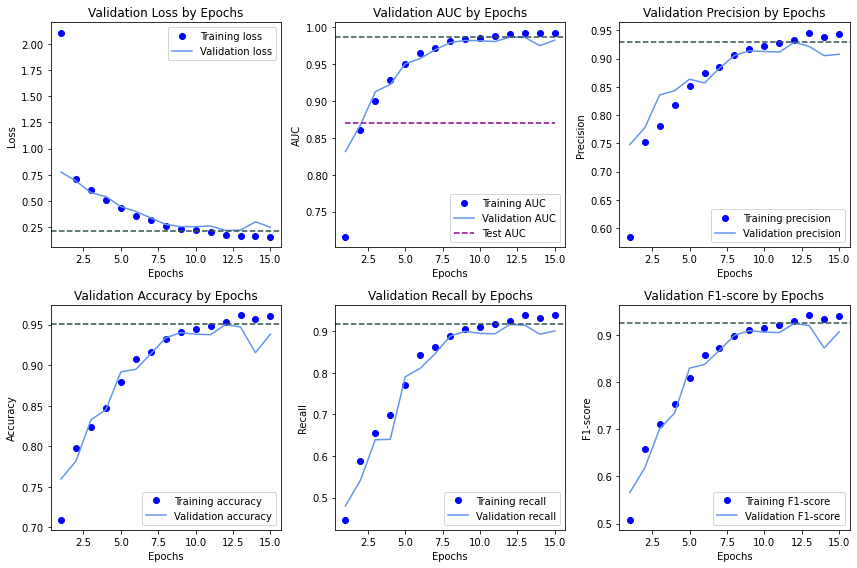

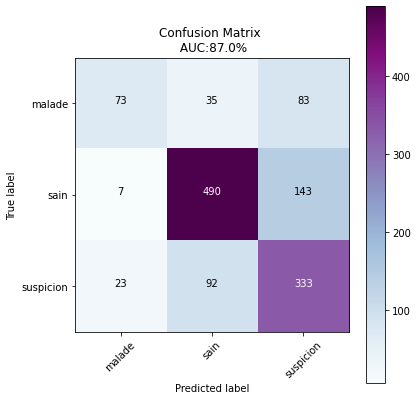

 
------ Valeurs des métriques du modèle ------
Loss =  0.9995003342628479
AUC =  0.8656441569328308
Precision =  0.706677258014679
Accuracy =  0.8021421432495117
Recall =  0.6950742602348328
F1-score =  0.700278639793396
Total Time:8.67


In [ ]:
# Train Model: Base Model
# get base
conv_base = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.4,dense_node =512,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        = callbacks  # early stopping 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot training metrics
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['malade','sain','suspicion'])

# Save the Model
model.save(os.path.join(DIR_MODELS,'DenseNet121_base_model.keras'))

# display runtime
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))



## **Réglages des hyper paramètres du modèle**

In [ ]:
# function to build the model
# add an additional conv layer with dropout and batch normalization
def build_transfer_model(conv_base,dropout,conv_nodes,dense_node,learn_rate,metric):
    """
    Build and compile a transfer learning model
    """
    
    # clear previous run
    backend.clear_session()
    
    # build the model
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())

    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(dropout +0.10))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(3,activation='softmax'))


    # complile the model
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric )
    
    model.summary()
    return model

## **Augmentation de la capacité du  modèle en ajoutant des couches de convolution**

 ### *Entrainement du modèle sur plus de couches : 50*

No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 6, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 5, 6, 1024)        0         
                                                                 
 batch_normalization (BatchN  (None, 5, 6, 1024)       4096      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 5, 6, 1024)        9438208   
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 6, 1024)        9438208   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 3, 1024)       0         
 )        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
128/128 - 53s - loss: 1.1450 - auc: 0.7100 - precision: 0.5859 - accuracy: 0.7019 - recall: 0.3606 - f1_score: 0.4464 - val_loss: 0.8279 - val_auc: 0.7897 - val_precision: 0.6193 - val_accuracy: 0.7162 - val_recall: 0.4761 - val_f1_score: 0.5203 - 53s/epoch - 415ms/step
Epoch 2/50
128/128 - 39s - loss: 0.8265 - auc: 0.7993 - precision: 0.6874 - accuracy: 0.7502 - recall: 0.4595 - f1_score: 0.5476 - val_loss: 1.0192 - val_auc: 0.7024 - val_precision: 0.5177 - val_accuracy: 0.6657 - val_recall: 0.3990 - val_f1_score: 0.4362 - 39s/epoch - 307ms/step
Epoch 3/50
128/128 - 39s - loss: 0.7569 - auc: 0.8377 - precision: 0.7003 - accuracy: 0.7720 - recall: 0.5522 - f1_score: 0.6168 - val_loss: 0.8644 - val_auc: 0.7747 - val_precision: 0.6470 - val_accuracy: 0.7232 - val_recall: 0.3844 - val_f1_score: 0.4652 - 39s/epoch - 306ms/step
Epoch 4/50
128/128 - 39s - loss: 0.6698 - auc: 0.8772 - precision: 0.7511 - accuracy: 0.8072 - recall: 0.6306 - f1_score: 0.6849 - val_loss: 0.6401 - val_

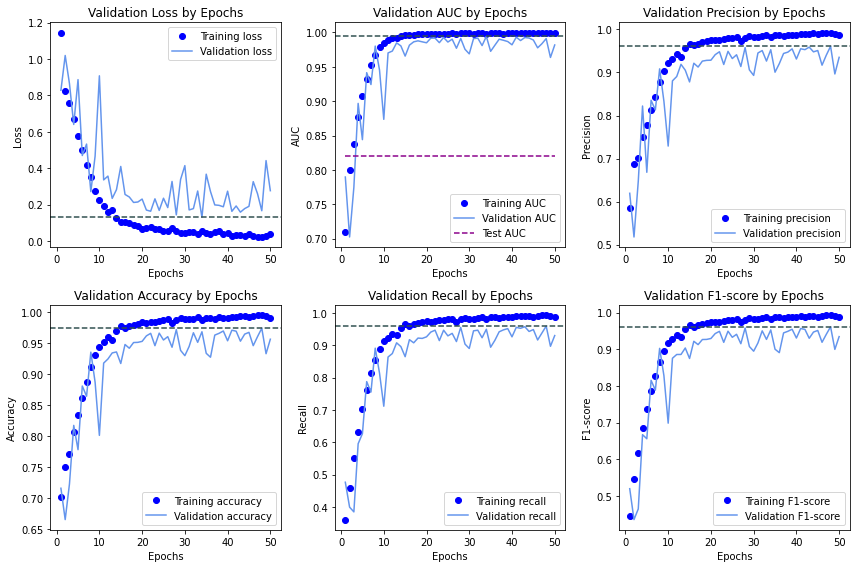

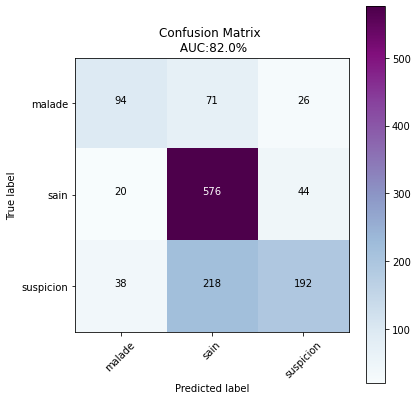

 
------ Valeurs des métriques du modèle ------
Loss =  2.1226065158843994
AUC =  0.8238743543624878
Precision =  0.6787687540054321
Accuracy =  0.7844758629798889
Recall =  0.6724002957344055
F1-score =  0.6745742559432983
Total Time:33.51


In [ ]:
# Base Model: Plus Additional Capacity
# training parameters
EPOCHS        = 50
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 10,restore_best_weights=True)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 accuracy,
                 tf.keras.metrics.Recall(name='recall'),
                 f1_score
                 ]



# Train Model: Base + Additional Capacity
# get base
conv_base = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.5,conv_nodes=1024,dense_node =1024,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['malade','sain','suspicion'])

# Save Model
model.save(os.path.join(DIR_MODELS,'DenseNet121_model_added_capacity.keras'))

# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

## **Trouver les meilleurs paramètres (à executer qu'une seule fois)**

In [ ]:
#Tune Hyperparameters  (not run for brevity)
# define Hyperparameters 
hp                   = kt.HyperParameters()
DROP_RATES           = [0.30,0.40,0.50]
CONV_NODES           = [512,1024,2048]
DENSE_NODES          = [512,1024,2048]
LEARN_RATE           = [0.001,0.0001]
    

# # get base
CONV_BASE = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# # unfreeze layers for training
freeze_layers(CONV_BASE,trainable_layers='none')

# # function to build the model
def build_model(hp):
   
#     # clear previous run
  backend.clear_session()

#     # Searchable parameters
  dropout    = hp.Choice('dropout',DROP_RATES)
  conv_nodes = hp.Choice('conv_node',CONV_NODES)
  dense_node = hp.Choice("dense_node",DENSE_NODES)
  learn_rate = hp.Choice("learn_rate",LEARN_RATE)
   
    
#     # build the model
  model = Sequential()
  model.add(CONV_BASE)
  model.add(Dropout(dropout))
  model.add(BatchNormalization())

  model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
  model.add(Conv2D(conv_nodes,3,padding='same',activation='relu'))
  model.add(MaxPooling2D())
  model.add(Dropout(dropout +0.10))
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(dense_node,activation='relu'))
  model.add(Dense(3,activation='softmax'))


#     # complile the model
  model.compile(
      optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
      loss      = 'categorical_crossentropy', 
      metrics   = ['accuracy'] )
  return model

tuner = Hyperband(
    build_model,
    objective = 'val_accuracy', 
    max_epochs = 10,
    directory = 'tune_hyperband',
    project_name = 'tune_hyperband',
    overwrite = True
    )

# # Hyperparameter Tuning
tuner.search(train_gen,
             epochs=10,
             verbose = False,
             validation_data=val_gen
             )

# # get the best model
best_model =tuner.get_best_models(num_models=1)[0]

# # show the optimal hyperparameters
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

No Layers Trainable: Using Base Model Weights


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


INFO:tensorflow:Oracle triggered exit


{'conv_node': 1024,
 'dense_node': 512,
 'dropout': 0.3,
 'learn_rate': 0.001,
 'tuner/bracket': 0,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}

## **Généralisation de la qualité d'apprentissage (en modifiant légèrement les images (orientation, zoom, ...))**

Found 4096 images belonging to 3 classes.


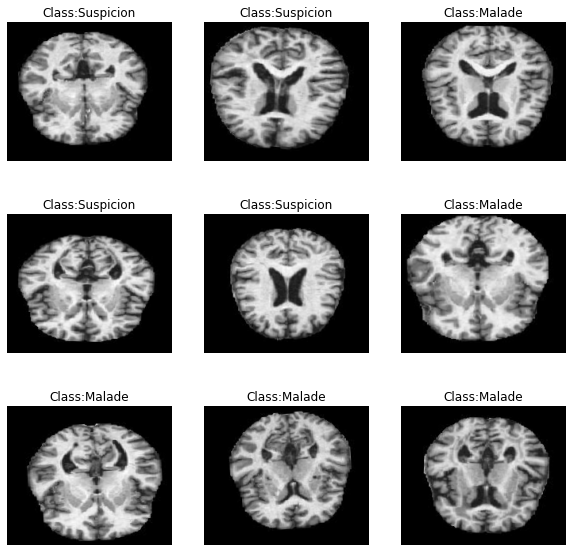

In [ ]:
# Data Augmentation on training images
train_images = ImageDataGenerator(rescale            = 1./255,
                                  rotation_range     = 5,
                                  zoom_range         = 0.10,
                                  width_shift_range  =0.05,
                                  height_shift_range =0.05)

# train image generator
train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',          
    seed        = SEED 
)

show_images(train_gen)

 ## **Re-apprentisage avec l'optimisation des paramètres et la généralisation**

No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 6, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 5, 6, 1024)        0         
                                                                 
 batch_normalization (BatchN  (None, 5, 6, 1024)       4096      
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 5, 6, 1024)        9438208   
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 6, 1024)        9438208   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 3, 1024)       0         
 )        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
128/128 - 65s - loss: 1.0719 - auc: 0.7150 - precision: 0.5788 - accuracy: 0.6996 - recall: 0.3633 - f1_score: 0.4434 - val_loss: 0.8290 - val_auc: 0.7981 - val_precision: 0.6894 - val_accuracy: 0.7367 - val_recall: 0.3941 - val_f1_score: 0.4834 - lr: 0.0010 - 65s/epoch - 509ms/step
Epoch 2/150
128/128 - 52s - loss: 0.8392 - auc: 0.7892 - precision: 0.6790 - accuracy: 0.7408 - recall: 0.4219 - f1_score: 0.5165 - val_loss: 0.8346 - val_auc: 0.7992 - val_precision: 0.6667 - val_accuracy: 0.7295 - val_recall: 0.4488 - val_f1_score: 0.5185 - lr: 0.0010 - 52s/epoch - 410ms/step
Epoch 3/150
128/128 - 51s - loss: 0.7690 - auc: 0.8275 - precision: 0.6940 - accuracy: 0.7651 - recall: 0.5283 - f1_score: 0.5976 - val_loss: 0.8519 - val_auc: 0.7962 - val_precision: 0.6436 - val_accuracy: 0.7497 - val_recall: 0.5073 - val_f1_score: 0.5796 - lr: 0.0010 - 51s/epoch - 400ms/step
Epoch 4/150
128/128 - 51s - loss: 0.7014 - auc: 0.8613 - precision: 0.7313 - accuracy: 0.7952 - recall: 0.6094 -

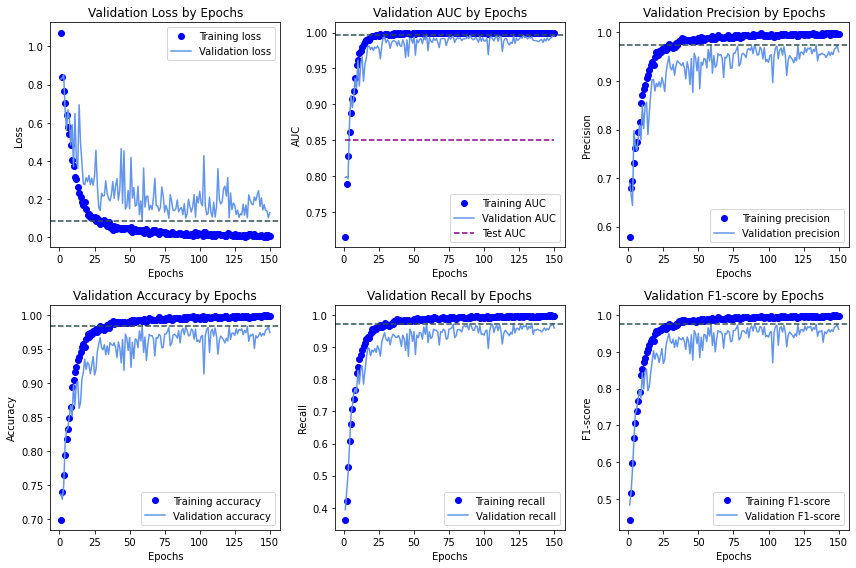

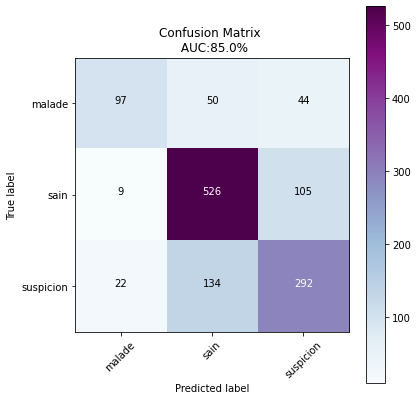

 
------ Valeurs des métriques du modèle ------
Loss =  1.956503987312317
AUC =  0.8527933359146118
Precision =  0.7185534834861755
Accuracy =  0.8113576173782349
Recall =  0.7146207690238953
F1-score =  0.7162559628486633
Total Time:131.6 mins


In [ ]:
# training parameters
EPOCHS        = 150
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 15,restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_auc',factor=0.9, patience=15, min_lr=1e-20, verbose=1, cooldown=3)
callbacks     = [reduce_lr]
metrics       = [tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 accuracy,
                 tf.keras.metrics.Recall(name='recall'),
                 f1_score
                 ]



# Train Model: Base + Optimized Hyperparameters + Data Augmentation
# get base
conv_base = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))

# freeze layers for training
freeze_layers(conv_base,trainable_layers='none')

# build and compile the model
model = build_transfer_model(conv_base,dropout=0.3,conv_nodes=1024,dense_node =512,learn_rate=0.001,metric=metrics)


# train
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
    callbacks        =callbacks 
)

# get class predictions
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

# get actual classes
y_actual = test_gen.classes

# plot
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['malade','sain','suspicion'])

# Save Model
model.save(os.path.join(DIR_MODELS,'DenseNet121_model_added_capacity.keras'))

# time
toc = time.perf_counter()
print("Total Time:{} mins".format(round((toc-tic)/60,2)))

## **Visualisation finale sur les données d'entrainement et labels prédit en fonction de l'apprentissage**

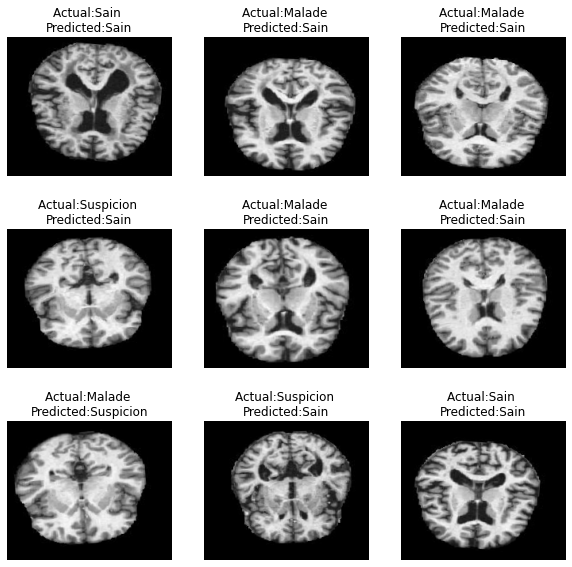

In [ ]:
# show_images and labels
show_images(train_gen,y_pred)